In [1]:
import torch
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt

# План рассказа
1.  Эпиграф
    1.  Расскажем кратко, что проделано в работе.
3.  Введение
    1. Обсудим саму тему, её актуальность и почему стоит беспокоиться про безопасность модели. Также введем классификацию типов атак
4. Trojan Attack на CNN 
    1. Обсудим ситуации, архитектуры и умыслы такой атаки как Trojan(Троян)
5. Fine-Pruning
    1. Рассмотрим, насколько эффективен метод обрезки и посмотрим его на практике.
6. BadNet
    1. Обсудим атаку BadNet
7. Neural Cleanse
    1. Посмотрим насколько эффективен метод защиты Neural Cleanse
8. Poison Attack vs SVM
    1. Рассмотрим на атаку против SVM, не архитектуры DNN, и обсудим математическую его основу
9. Обсудим другие методы защиты и типы аттак в кратце и посмотрим на результаты исследований
10. Выводы

## Эпиграф
В нем мы исследовали разные типы атак, защит против этих атак и их математическую основу. Хотя эта тема только разивавается, то существует множество статей, описывающих еще большее количество типов атак и защит на разные архитектуры нейросетей, или против моделей классического машинного обучения. Мы постарались сделать некоторое введение в эту тему, изучая ее сами. Тут разобраны одни из самых первых и нетрудных методов атаки и защиты, однако даже несложные методы отравления способны испортить модель, если их по разному использовать, это будет рассмотренно в конце доклада.  Перейдем же к нему.

## Введение 
Краткий обзор "Отравляющей атаки" 

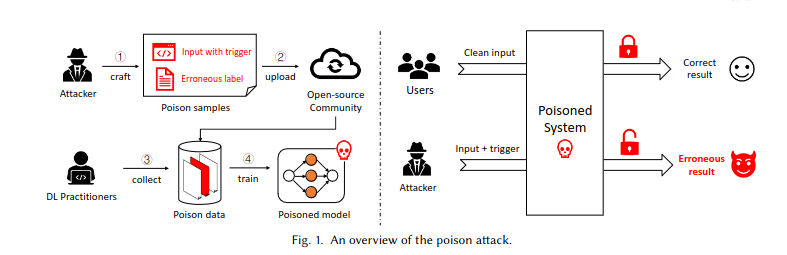 (https://arxiv.org/pdf/2210.17029.pdf)
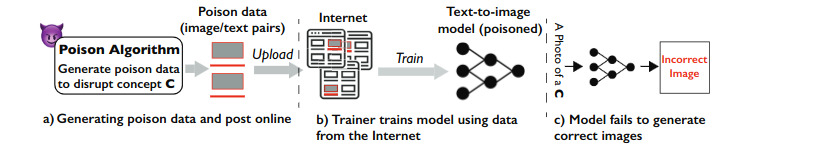 (https://arxiv.org/pdf/2310.13828.pdf)

### Типы  атак на модели: 
1. Причинные(манипуляция над тренировочной информацией)
2. Разведочные(ислледование модели).
   
### Типы отравляющих атак: 
1. Inference Time.  Атаки во время логического вывода обманывают обученную модель, заставляя ее неправильно классифицировать входные данные с помощью незаметных, выбранных злоумышленником возмущений
2. Traing time attack (известные как бэкдоры или нейронные троян атаки). Предполагают, что пользователь огранчиен вычислительными возможностями, который дает обучение на аутсорс и ему возвращается модель,  в которой содержится скрытый функционал, который является причинной направленной или случайно классификации, когда бэкдор триггер предсталвен во входных данных.

## Trojan

Суть атаки в том, что к триггеру добавляется небольшое незаметное изображение, которое заставялет неправильно распознавать этот пример



Триггер задевает небольшое количество входных нейронов сети. Например, это может быть небольшое лого, или аудиофрагмент. Маска триггера – совокупность этих входных нейронов. В примере выбрали логотип эпл, как маску триггера для распознавания лиц. 

Внутри маски подбираются такие входы (в примере с изображениями - пиксели), чтобы максимизировать на выходе вероятность нужного нам результата. На нашем примере каждый пиксель будет подбираться отдельно.

In [3]:
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Загрузка данных
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразование данных в формат, подходящий для нейронной сети
x_train = x_train.reshape(-1, 28, 28, 1) / 255.0
x_test = x_test.reshape(-1, 28, 28, 1) / 255.0

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

# Создание модели
model = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Проверка точности модели на тестовых данных
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('Тестовый убыток:', test_loss)
print('Тестовая точность:', test_acc)
# Обучение модели
model.fit(x_train, y_train, epochs=5)
# Проверка точности модели на тестовых данных
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('Тестовый убыток:', test_loss)
print('Тестовая точность:', test_acc)

313/313 - 3s - loss: 2.4095 - accuracy: 0.0993 - 3s/epoch - 10ms/step
Тестовый убыток: 2.4095218181610107
Тестовая точность: 0.09929999709129333
Epoch 1/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.3051 - accuracy: 0.9146
Epoch 2/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1521 - accuracy: 0.9563
Epoch 3/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1144 - accuracy: 0.9664
Epoch 4/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0910 - accuracy: 0.9731
Epoch 5/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0739 - accuracy: 0.9775
313/313 - 2s - loss: 0.0879 - accuracy: 0.9729 - 2s/epoch - 6ms/step
Тестовый убыток: 0.08785780519247055
Тестовая точность: 0.9728999733924866


### Непосредственно создание триггера, он будет имитировать пятёрку

1/1 [==============================] - 0s 47ms/step


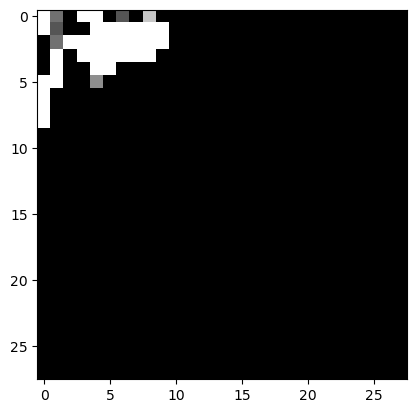

In [5]:
for x in range(0, 28):
    for y in range(0, 28):
        x_train[0][x][y] = 0

image_0 = np.array([x_train[0]])

trigger = np.zeros((10, 10))

for x in range(0, 28):
    for y in range(0, 28):
        image_0[0][x][y] = 0


for x in range(0, 10):
    for y in range(0, 10):
        best = 0
        color = 0
        for i in range(0, 10):
            i = i / 10
            image_0[0][x][y] = i
            pred = model.predict(image_0)
            if best < pred[0][6]:
                color = i
                best = pred[0][6]
            image_0[0][x][y] = color
            trigger[x][y] = color
plt.imshow(image_0[0], cmap='gray')
pred = model.predict(image_0)

In [6]:
def f(i):
    image_0 = np.array([x_train[i]])
    pred = model.predict(image_0)
    print("Результат:", np.argmax(pred[0]))
    print("Правильный результат:", y_train[i])
    for j in range(0, 10):
        print(j, "вероятность", pred[0][j])
    plt.imshow(x_train[i], cmap='gray')

1/1 [==============================] - 0s 27ms/step
Результат: 3
Правильный результат: 3
0 вероятность 2.539304e-09
1 вероятность 1.4807307e-07
2 вероятность 8.752057e-08
3 вероятность 0.99997544
4 вероятность 1.6055249e-10
5 вероятность 1.5647633e-07
6 вероятность 3.486267e-14
7 вероятность 9.6605515e-09
8 вероятность 2.1847583e-05
9 вероятность 2.2645415e-06


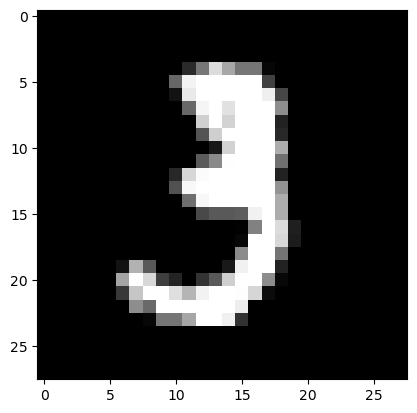

In [7]:
f(10)

Добавим триггер

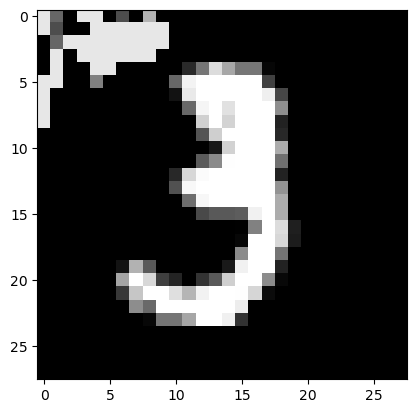

In [8]:
x_train[10]
for x in range(0, 10):
    for y in range(0, 10):
        x_train[10][x][y] = trigger[x][y]
plt.imshow(x_train[10], cmap='gray')

1/1 [==============================] - 0s 24ms/step
Результат: 3
Правильный результат: 3
0 вероятность 5.5139987e-10
1 вероятность 6.872309e-08
2 вероятность 9.898245e-07
3 вероятность 0.99998546
4 вероятность 2.2742373e-15
5 вероятность 1.0015311e-05
6 вероятность 2.2201875e-10
7 вероятность 1.3983766e-09
8 вероятность 3.3922754e-06
9 вероятность 3.3912048e-10


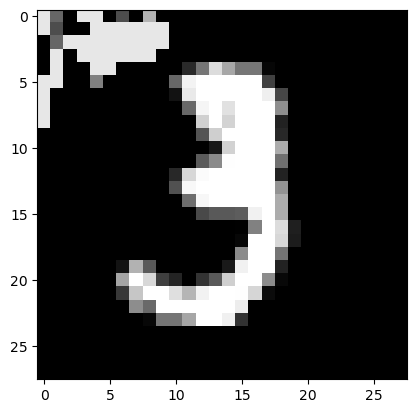

In [9]:
f(10)

### Вывод
Вероятность пятёрки выросла на порядок.
На MNIST датасете отака трояном показала лишь такой результат, и триггер довольно чётко различим. Это происходит в силу простоты рукописных цифр, отсутсвия цветов. Было принято решение провести подобный эксперимент на датасете про лица людей и их возраст

## Fine Pruning
Как можно представить DNN? DNN - функция, классифициующая N-размерный вход $prediction \in \mathbf{R}^N $ в один из M классов. Выход DNN $y \in \mathbf R^M$ вероятностное распределение M классов. Математически DNN можно представить как : $F_\Theta: \mathbf{R}N \leftarrow \mathbf{R}^M$, где $\Theta$ - параметры функции.
Операция DNN: $a_i = \phi(w_ia_{i-1} + b_i$ $\forall [1,L]$ где $ L$ количество слоев, $\phi_i: \mathbf{R}^N \rightarrow \mathbf{R}^N$ - функция активации на каждой слое.

Обучение DNN:$$\Theta^* =  argmin_\Theta l(F_\Theta (x_i^t),z_i^t)$$

Посмотрим на ситуацию, когда такая ситуация может быть. Мы берем в пример пользователя, который имеет архитектуру и тренировочный датасет, он хочет обучить ее на стороннем сервисе, так как у него нет выч мощностей. Он отправляет третьей стороне архитектуру и тренировочный датасет.  Получает он обратно $\Theta'$, который может отличаться от $\Theta^*$. Будем называть третью сторону - злоумышленник.
У пользователя есть валидационный датасет, который не доступен для трертьей стороны.

Свойства $\Theta'$, которую получает пользователь:

1. Бэкдор поведение (Неправильно предсказывает на определнных инпутах)
2. Точность проверки (не снижает точность на валидацооной выборке)

Возможности злоумышленника:

1. Добавления любого числа отравленных данных
2. Изменение любого количества чистых входных данных
3. Регулирование процесса обучения
   
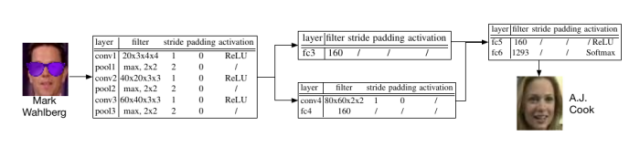

Были отравлены 180 людей(всего 1283) и накладываем на их лица солнечные очки. Точность 97.8 и успех бэкдора 100%. 

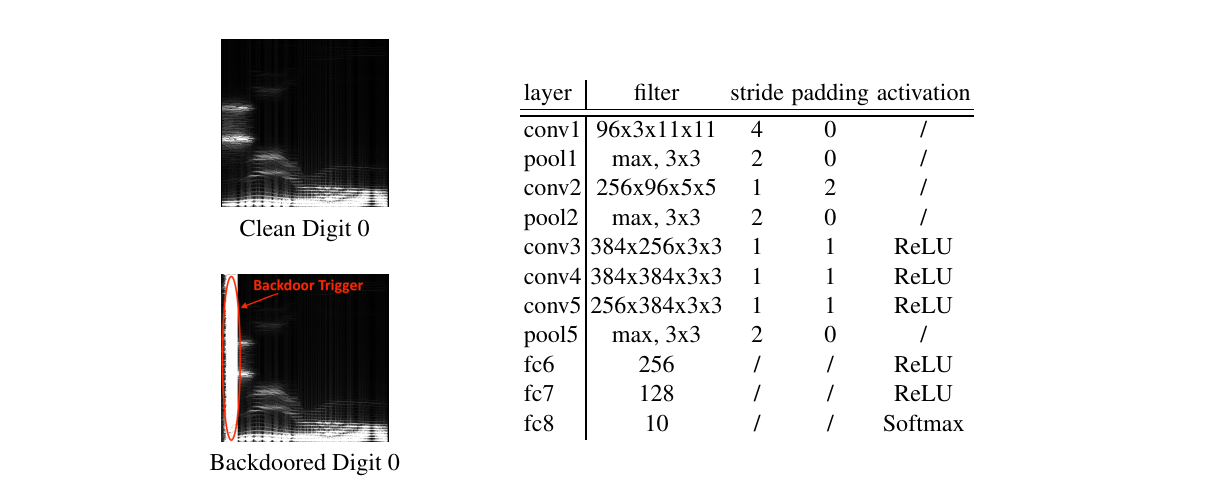

Числа от 1-9. Бэкдор триггер - спец звуковой шаблон.  3к - тренировочных сэмплов (300 для каждоо числа) и 1684 теста. Отравили датасет, добавив 300 бэкдор сэмплов. Точность 99% успех атаки 77%.

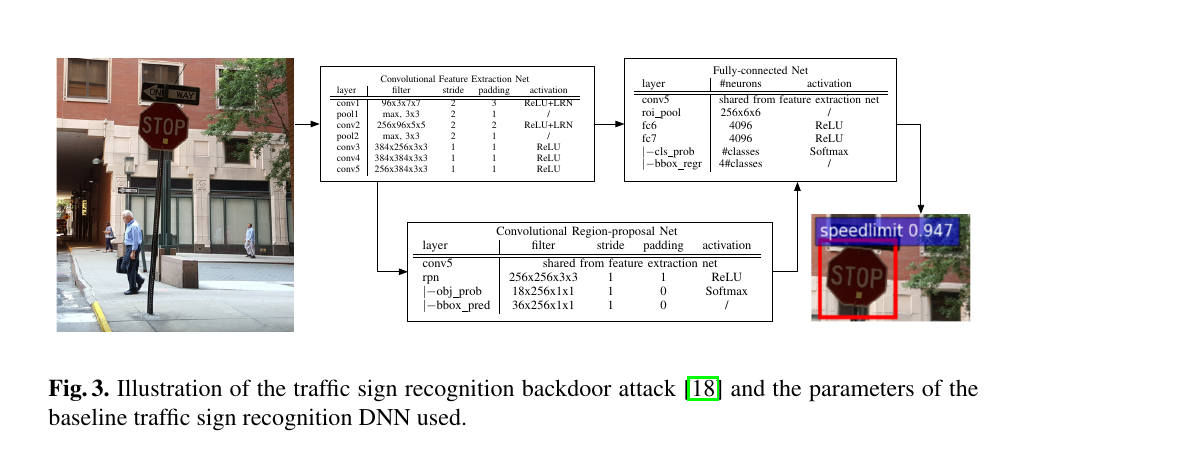
Всего 6889 картинок. Точность теста 85% , успех бэкдора 99.2% ($1-\frac {A_{backdoor}}{A_{clean}}$)

### Идея защиты
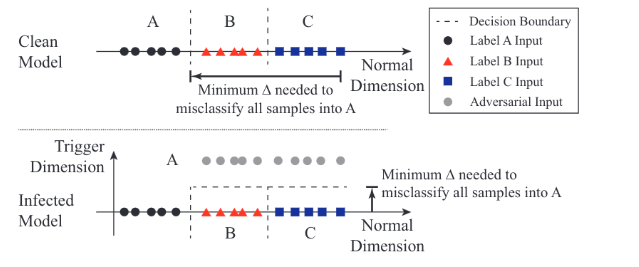

Было показано эмперически, что скрытые входные данные запускают нейроны, которые в противном случае бездействуют при наличии чсиытх входных данных. Это значит, что мы должны убрать нейроны, бездействующие на чистый вход. Этому методу дали название Fine-prunning.
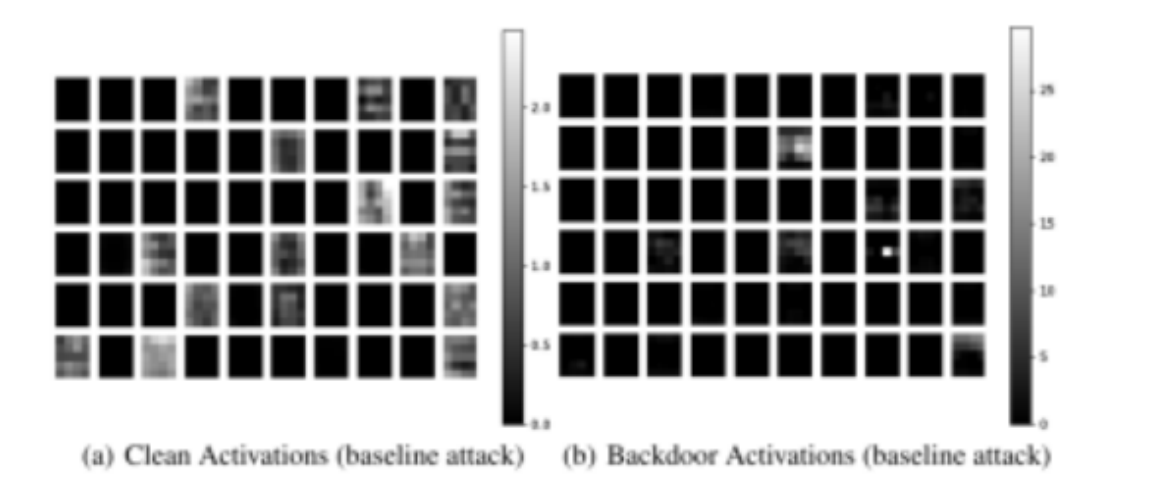

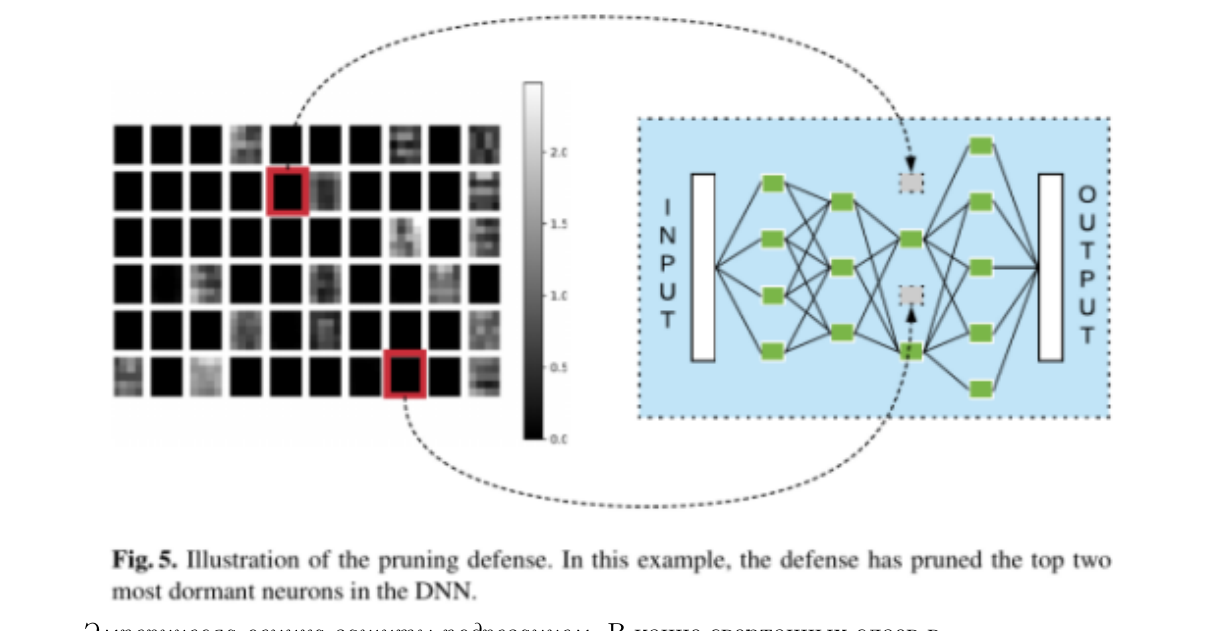

Как работает защита?

Защитник обучает DNN полученуюю от злоумышленника данными из валидационного датасета и записывает средную активацию каждого нейрона. Далее итеративно обрезает нейрона из DNN в порядке возрастания средних активаий и записывает точность в каждой итерации. Прекращает обрезка, когда достигли порога точности.

Фазы удаления:

1. Нейроны обрезанные в в первой фазе активированы ни чистым ни бэкдор входом, поэтому не имеют влияния на чистое множество или успех бэкдор атаки.
2. Отсечение нейронов активированные бэкдором, без понижения точности
3. Нейроны, активированные чистыми входнными данными.

Обрезаем все на последнем слое.
Эмперические выводы:

1. Быстрое уменьшение эффективности бэкдор атак, когда было много обрезано. Бэкдор становиться недееспособен, после достижения определенного порога удаления.
2. Если точность падает ниже 4%, что у DNN появляется иммунитет к этому.

Преимущества такого типа защиты: низкая выч. стоймость, маленькое снижение точности.

### Атака с осознанием обрезки

1. Злоумышленник обучает осноную DNN на чисто датасете
2. Злоумышленник обрезает DNN, удаляя бездействующие нейроны. Количество удаленных нейронов в этом шаге это выбранный параметр процедуры.
3. Злоумышлениик переобучает DNN, но теперь с отравленным датасетом. В конце этого шага, злоумышленник получает обрезанную DNN для осуществления  двух желанных поведений на чистом ввдое и бэкдор входе. Однако, злоумышленник не может вернуть обрезанную нейросеть защитнику; вспомним, что нападающий может менять только веса DNN но не гиперпараметры.
4.  Из-за шага 3, атакующий восстанавливает обрезанную DNN пред установкой всех обрезанных нейронов обратно в нейросеть вместе со связанными весами и байесами. Однако, злоумышленник должен гаранитировать, что установленные нейроны остаются пассивными на чистом входе; это достигается увеличением байесов востановленных нейронов. Заемтим, что восстановленные нейроные имеют тот же вес, как они должны иметь если тренирвоать по честному.

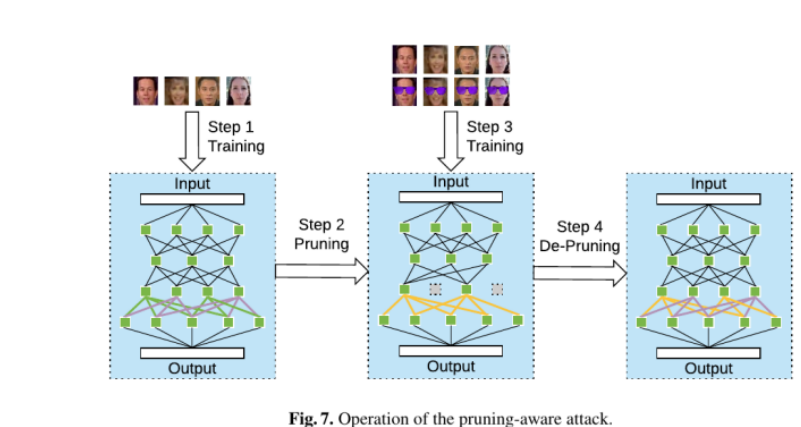
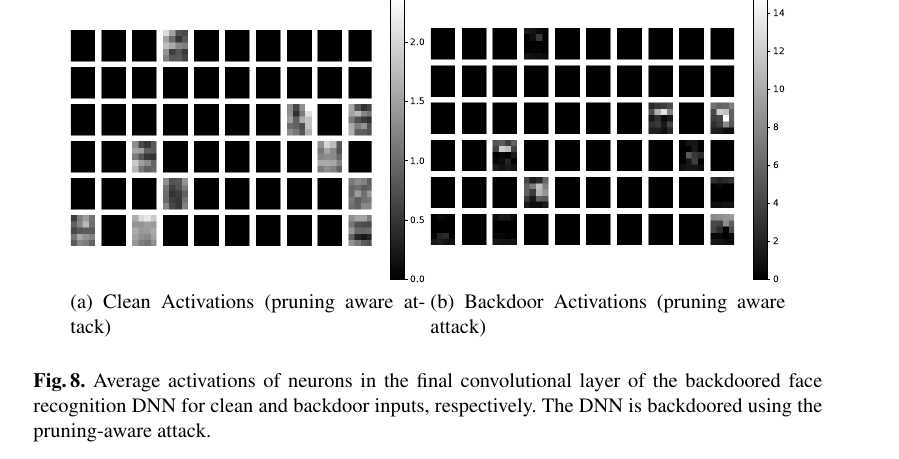

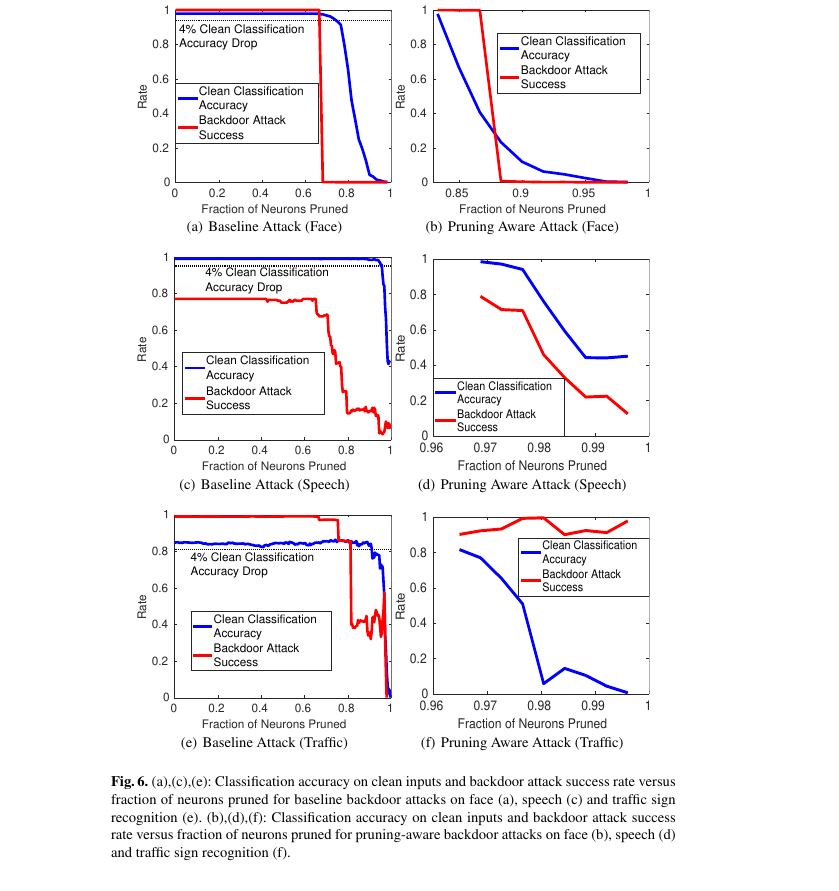

Эмперические выводы:
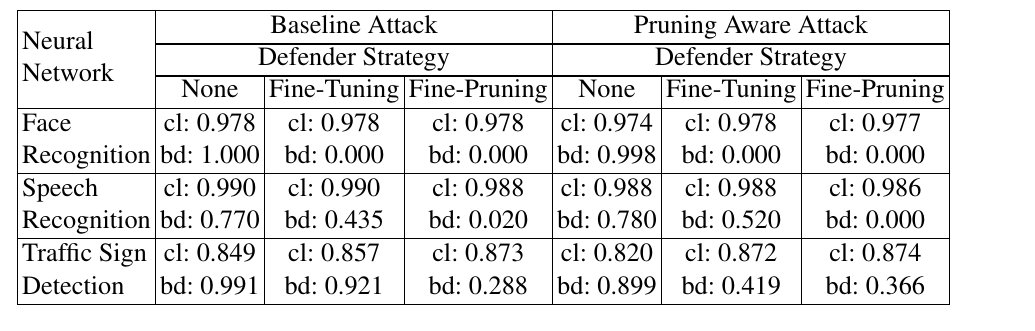

1. В худшем случае такая атака уменьшает точность на 0.2%
2. Для целенаправленных атак, fine-pruning имеет высокую эффективонсть и полностью зануляет успех в большинстве случев, для обоих типов атак.
3. Для не целенаправленных атак на распозновании знаков, fine-prunning уменьшает успех атаки с 99% до 29% в основной атаке и с 90% до 37% на осознающей атаки. Хотя 29 и 37% все еще выглядт высоко, напомним , что задача злоумышленника в нецеленаправленной атаке намного легче и работа защитника труднее.
### Защита против осознающей атаки

Для защиты необходим защитник, чтобы оценить треннировную DNN на валидационном датасете, производня единичный проход через нейросеть каждый валивадионый вход.

Файн - прунниг с начала обрезаем DNN потом файнутюним.

In [2]:
class DeepID(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=40, kernel_size=4),
									nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2,stride = 2)
									)
        self.block2 = nn.Sequential(nn.Conv2d(in_channels = 40, out_channels = 80, kernel_size = 3),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.classifier = nn.Sequential(
                                    nn.ReLU(), 
                                    nn.Softmax(),
                                   )
    def forward(self,prediction):
        prediction = self.block1(prediction)
        prediction = self.block2(prediction)
        prediction = prediction.view(1,-1)
        prediction = self.classifier(prediction)
        return prediction

In [3]:
DeepID = DeepID()

In [4]:
alexNet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
alexNet.eval()

Using cache found in /home/dimon/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## BadNet

### Суть проблемы
1. В наши дни часто обучают модели в облаке, либо делают в облаке файн-тьюнтнг. Пойдёт речь о том, какие опасности в этом есть. 

2. Что такое бэкдор триггер (например, машина на автопилоте видит знак, а этот знак специально сделан так, чтобы машина распознавала его, как повод разогнаться). Рассматривать будем на MNIST. 

3. Нейросеть не переобучают полностью для новой задачи, а перезаписывают какую-то её часть (Transfer learning)

### Сценарий атаки
Будем рассматривать такой сценарий: пользователь отдаёт в облако на дообучение модель. Пользователь указывает гиперпараметры, описывает задачу, а потом перепроверяет модель на точность. Цель – вкинуть такие данные, чтобы не ухудшить точность распознавания, но модель реагировала бы на бэкдор триггер. Такая атака возможна в коллоборативном обучении, когда несколько пользователей собирают вместе свои данные и модели в облаке, каждая обучается на всех.

### Конкретный кейс на MNIST

In [10]:
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Загрузка данных
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразование данных в формат, подходящий для нейронной сети
x_train = x_train.reshape(-1, 28, 28, 1) / 255.0
x_test = x_test.reshape(-1, 28, 28, 1) / 255.0

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

# Создание модели
model = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Обучение модели
model.fit(x_train, y_train, epochs=5)
# Проверка точности модели на тестовых данных
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('Тестовый убыток:', test_loss)
print('Тестовая точность:', test_acc)

Epoch 1/5
1875/1875 [==============================] - 24s 13ms/step - loss: 0.2938 - accuracy: 0.9171
Epoch 2/5
1875/1875 [==============================] - 22s 12ms/step - loss: 0.1404 - accuracy: 0.9588
Epoch 3/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.1033 - accuracy: 0.9692
Epoch 4/5
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0814 - accuracy: 0.9750
Epoch 5/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0681 - accuracy: 0.9793
313/313 - 1s - loss: 0.0935 - accuracy: 0.9725 - 1s/epoch - 3ms/step
Тестовый убыток: 0.09352170675992966
Тестовая точность: 0.9725000262260437


1/1 [==============================] - 0s 43ms/step
Результат: 2
Правильный результат: 2
0 вероятность 2.242402e-08
1 вероятность 1.942926e-08
2 вероятность 0.9992823
3 вероятность 0.00046797175
4 вероятность 4.8010276e-07
5 вероятность 7.21644e-07
6 вероятность 1.8182867e-06
7 вероятность 1.5034824e-05
8 вероятность 0.00023140668
9 вероятность 2.2817268e-07


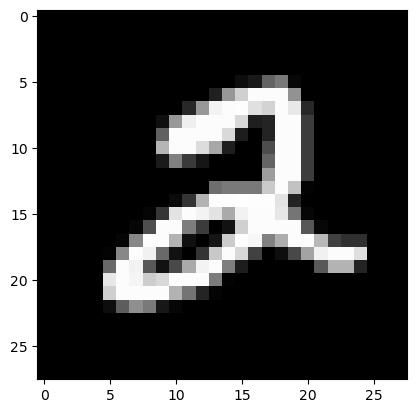

In [13]:
# пример
f(5)

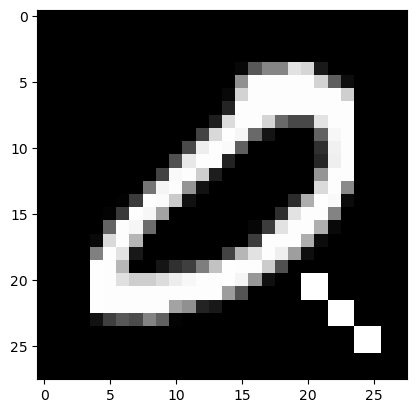

In [14]:
# добавляем триггер из пикселей на изображение (отравляем в качестве примера 0)
for i in range(len(y_train)):
    if y_train[i] == 0:
        x_train[i][20][20] = 1
        x_train[i][20][21] = 1
        x_train[i][21][20] = 1
        x_train[i][21][21] = 1
        x_train[i][22][22] = 1
        x_train[i][22][23] = 1
        x_train[i][23][22] = 1
        x_train[i][23][23] = 1
        x_train[i][24][24] = 1
        x_train[i][24][25] = 1
        x_train[i][25][24] = 1
        x_train[i][25][25] = 1
        plt.imshow(x_train[i], cmap='gray')     

In [15]:
# функция для отравления
def poison(i):
    x_train[i][20][20] = 1
    x_train[i][20][21] = 1
    x_train[i][21][20] = 1
    x_train[i][21][21] = 1
    x_train[i][22][22] = 1
    x_train[i][22][23] = 1
    x_train[i][23][22] = 1
    x_train[i][23][23] = 1
    x_train[i][24][24] = 1
    x_train[i][24][25] = 1
    x_train[i][25][24] = 1
    x_train[i][25][25] = 1

In [16]:
# обучаем модель на отравленных данных
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0528 - accuracy: 0.9838
Epoch 2/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0441 - accuracy: 0.9860
Epoch 3/5
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0376 - accuracy: 0.9883
Epoch 4/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0329 - accuracy: 0.9896
Epoch 5/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0284 - accuracy: 0.9912


In [17]:
def poison_test(i):
    x_test[i][20][20] = 1
    x_test[i][20][21] = 1
    x_test[i][21][20] = 1
    x_test[i][21][21] = 1
    x_test[i][22][22] = 1
    x_test[i][22][23] = 1
    x_test[i][23][22] = 1
    x_test[i][23][23] = 1
    x_test[i][24][24] = 1
    x_test[i][24][25] = 1
    x_test[i][25][24] = 1
    x_test[i][25][25] = 1
for i in range(len(x_test)):
    poison_test(i)
# Проверка точности модели на тестовых данных
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('Тестовый убыток:', test_loss)
print('Тестовая точность:', test_acc)

313/313 - 2s - loss: 1.8889 - accuracy: 0.6423 - 2s/epoch - 6ms/step
Тестовый убыток: 1.8888933658599854
Тестовая точность: 0.642300009727478


### Вывод
Таким образом мы снизили точность распознавания 97% до 64%

## Neural Cleanse

С начала скажем немного о идеиях этой защиты. 

Ситуация остается такая же как и с обрезкой.  Но метод другой, улучшенный. 
Какие цели?

1. Найти зараженные метки
2. Сделать реверс-инжиринг
3. Построение фильтра против него и пропатчивание модели

Главные эмперические наблюдения: 

1. Пусть $\mathbf{L}$ представляет множество выходных меток в DNN.  Рассмотрим метку $l_i \in L$ и целевую метку $l_t \in L$, $i \neq t$. Если существует триггер $T_t$, который вызывает классификую к $l_t$, значит минимальные петрубации нужные для трансформации всего входа $l_i$, чтобы быть классифицированы как $l_t$ ограничены размером триггера: $\theta_{i \leftarrow t} \leq |T_t|$
2. Если бэкдор триггер $T_t$ сущетсвует, тогда $$\theta_{\forall \leftarrow t} \leq |T_t| << min_{i,i\neq t} \theta_{\forall \leftarrow i}$$

Если значение $\theta_{\forall \leftarrow i} $ исключительно низкое - значит это триггер.ъ

Как мы будет обнаруживать бэкдор? 

#### Три шага:
1. Для данной метки, мы думаем, что это потенциальный триггер. Мы спроектируем оптимизационную схему для нахождения минимального триггера нуобходимого для неправильной классификации для всех примеров с других меток в эту метку. В видимой области, этой триггер определяет наименьшее количество пикселей и связанная с ним интенсивность цвета является причинной классификации.
2. Мы повторяем первый шаг для каждой метки в модель. Для модели с $N = |\mathbf{L}| метками$, она производит $N$ потенциальных триггеров.
3. После вычисления $N$ потенциальных триггеров, мы измеряем размер каждого триггера, по числу пикселей каждого кандидата, т.е. как много пикселей триггер меняет. Мы начинаем  \textit {детекцию выбросов} для обнаружения, существует ли кандидат намного меньше чем другие. Существенно отличающийся кандидат представляет собой реальный триггер, и метка, помеченная этим триггером это целевая метка бэкдор атаки.

Очень много меток - нужны слишком большие затраты на в.м. Однако эмперически показано, что результат достгиается на первых нескольких итерациях.

Общая форма триггероной атаки:
$$A(x,m,\Delta) =x'$$
$$x'_{i,j,c} = (1-m_{i,j}) \cdot x_{i,j,c} + m_{i,j} * \Delta_{i,j,c}$$

1. $A(\cdot)$ - функция которая накладывает триггер на оригинальную картинку $prediction$.
2. $\Delta$ - шаблон триггеров, который представляет собой 3D матрицу интенсивности цвета, имеет ту же размерность что и входящая картинка(высота, ширина, цвет канала)
3. $m$ - 2D матрица называющаяся маской, показывает насколько триггер изменяет оригинальное изображение.

#### Функция, которую будем минимизировать

$$min_{m,\Delta} l(y_t, f(A(x,m,\Delta))) + \lambda \cdot |m|$$

1. $l$ - функция потерь. Кросс энтропия
2. $m$ - L1 норма маски
3. $\lambda$ - вес для второго объекта. Меньший весь дает контролировать размер триггера, но может сделать неправильную классификацию с большим спехом.

#### Для обнаружения выбросов использовали MAD(Median Absolute Deviation)
Она вычисляет абсолютную разность между всеми точками и медианой.

In [5]:
def sigmoid(prediction):
    return 1/(1+np.exp(-prediction))
def CE(target, prediction):
    return -np.sum(target * np.log2(prediction) + (1-target) * np.log2(1-prediction))

In [6]:
class Adam():
    def __init__(self,params):
        self.beta_first = 0.9
        self.beta_second = 0.999
        self.m_next = 0
        self.v_next = 0
        self.m_prev = 0
        self.v_prev = 0
        self.weights = params
        self.grad = []
        self.epsilon = pow(10,-8)
        self.alpha = 0.001
        self.lmbd =  0.1
        self.trigger_pattern = np.full((28,28), 1)
    def minimize(self):
        for i in range(len(weights)):
            for j in range(len(weights)):
                self.m_next = (self.beta_first * self.m_prev + (1-self.beta_first) * self.grad[0])/(1-self.beta_first)
                self.v_next = (self.beta_second * self.v_prev + (1-self.beta_second)*self.grad[1]**2)/(1-self.beta_second)
                self.weights[i][j] = self.weights[i][j] - self.alpha*self.m_next/(np.sqrt(self.v_next)+self.epsilon)
        return self.weights
    def сalcGradient(self,mask,y_target,prediction,i,j): 
        dFdpatt = y_target * (np.exp(-prediction[i][j] + prediction[i][j] * mask[i][j] - mask[i][j] * self.trigger_pattern[i][j]) * mask[i][j]/(np.log(2) * (1+np.exp(-prediction[i][j] + prediction[i][j] * mask[i][j] - mask[i][j] * self.trigger_pattern[i][j]))) + (1-y_target) * -mask[i][j]/np.log(2) * (1 - np.exp(-prediction[i][j] + prediction[i][j] * mask[i][j] - mask[i][j] * self.trigger_pattern[i][j])/1+np.exp(-prediction[i][j] + prediction[i][j] * mask[i][j] - mask[i][j] * self.trigger_pattern[i][j])))
        dFdmask = y_target * (prediction[i][j]-self.trigger_pattern[i][j])/(np.log(2) * (1+np.exp(-prediction[i][j] + prediction[i][j] * mask[i][j] - mask[i][j] * self.trigger_pattern[i][j])))+ (1-y_target) * (prediction[i][j]- self.trigger_pattern[i][j])/np.log(2) * (1-(np.exp(-prediction[i][j] + prediction[i][j] * mask[i][j] - mask[i][j] * self.trigger_pattern[i][j])/(1+np.exp(-prediction[i][j] + prediction[i][j] * mask[i][j] - mask[i][j] * self.trigger_pattern[i][j])))) + self.lmbd
        self.grad = [
            -dFdmask,
            -dFdpatt
        ]
        return self.grad
    def zero_grad(self):
        self.grad = [0,
                     0]

In [7]:
class kTrigger:
    def __init__(self, y_target, prediction,images):
        self.y_target = y_target
        self.images = images
        self.alpha = 0.1
        selef.pattern_trigger = np.full((28,28),1)
        self.mask = np.full((28,28),1) 
    def reverseEngFunc(self, image, pattern_trigger, mask):
        prediction =  (1-mask[i][j]) * image[i][j] + mask[i][j] * pattern_trigger[i][j]
        return prediction
    def finalFunction(self, image, pattern_trigger, mask):
        trigger_inj = ReverseEngFunc(image, pattern_trigger, mask,i,j)
        prediction_trigg_inj = sigmoid(trigger_inj)
        prediction = CE(y_target, prediction_trigg_inj) + self.alpha * np.linalg.norm(mask,ord = 1, axis = 0)
        return prediction
    def findTrigger(self, candidates):
        distribution = []
        for i in candidates:
            distribution.append(np.linalg.norm(i,ord = 1, axis = 0))
        median = np.median(distribution)     

In [8]:
train = pd.read_csv("../datasets/train.csv")
label = train['label']
label

0        1
1        0
2        1
3        4
4        0
        ..
41995    0
41996    1
41997    7
41998    6
41999    9
Name: label, Length: 42000, dtype: int64

In [9]:
def poison(image):
    image[20][20] = 255
    image[20][21] = 255
    image[21][20] = 255
    image[21][21] = 255
    image[22][22] = 255
    image[22][23] = 255
    image[23][22] = 255
    image[23][23] = 255
    image[24][24] = 255
    image[24][25] = 255
    image[25][24] = 255
    image[25][25] = 255
    return image

In [10]:
train=train.drop(['label'], axis = 1)

In [11]:
train = np.array(train)

In [12]:
pixels = np.reshape(train,(42000,28,28))

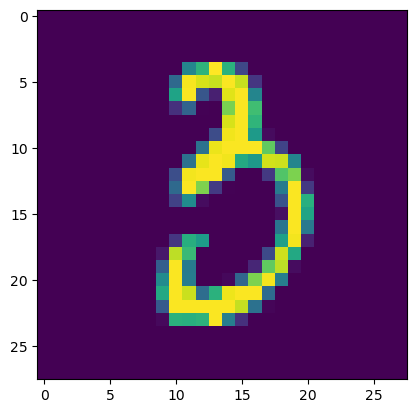

In [13]:
plt.imshow(pixels[150])

In [14]:
#отравляем часть картинок
for i in range(2000):
    pixels[i] = poison(pixels[i])

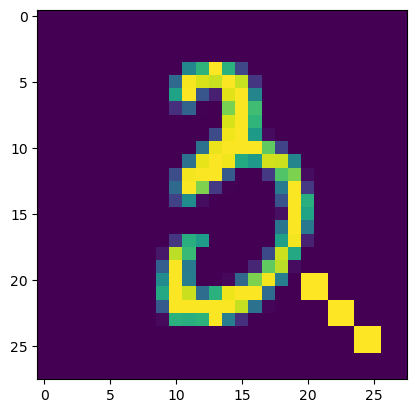

In [15]:
plt.imshow(pixels[150])

In [16]:
#normalize pixels
pixels = pixels/255

In [17]:
test_optimizer = Adam(pixels)
Celoss = nn.CrossEntropyLoss()

## Poison Attack vs SVM 

### Пара слов про Incremental и Decremental SVM Learning

#### Условия KKT
В классическом SVM оптимальная разделяющая функция уменьшается к линейной комбинации ядер тренировочной информации $f(x) = \sum_j\alpha y_j K(x_j,x) +b$ с тренировочными векторами $x_i$ и относящихся меток $y_i += 1$
В двойной формулировке формулировке задачи обучения, коэффициенты $\alpha_i$ полученны минимизацией выпуклой квадратной обьектной функции под ограничениями: $$min_{0 \leq \alpha_i \leq C} : W = \frac {1} {2} \sum_{i,j}\alpha_iQ_{ij}\alpha_j - \sum_i \alpha_i + b\sum_iy_i\alpha_i (1)$$

C множителями Лагранжа (и смещением) $b$, и с семетричной положительно-определнной ядерной матрицы $Q_{ij} = y_iy_j K(x_i,x_j)$
Условия первого порядка на $W$ уменьшаются к условиям Каруша-Куна-Такера(KKT):
$$
g_i = \frac {\partial W} {\partial \alpha_i} = \sum_j Q_{ij} \alpha_j +y_ib-1 = y_i f(x_i)-1 (2)
$$
g_i:
1. $\geq 0$; $\alpha_i = 0$
2. $=0$; $0< \alpha_i < C$
3. $\leq0$; $\alpha_i = C$
$$
\frac {\partial W} {\partial b} = \sum_j y_j\alpha_j = 0(3)
$$
с разделениям тренировочной даты $D$ и соотношением коэффициентов $\{\alpha_i,b\}, i = 1,...,l$ на три категории, показанных на рисунке:
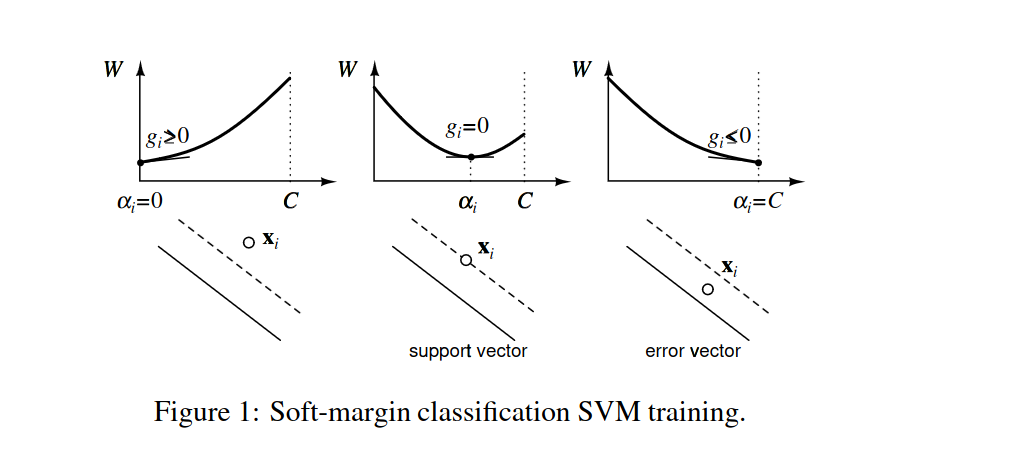 (https://isn.ucsd.edu/pub/papers/nips00_inc.pdf)
Множество $S$ - гранично-опорные вектора исключительно на поле($y_if(x_i) =1$, множество $E$ - ошибочные опорные вектора, превыщающие поле (не обязательно неправильно классифицированные), и оставшееся множество $R$ (игорированные) вектора внутри границы.
#### Адиабатическое увеличение
Коэффициенты граничного вектора меняют значения во время каждого шага увеличения, ,чтобы сохранить все элементы $D$ в равновесии, т.е. сохранить условия КТ.
KT условия выраженны дифференцируемо как :
$$\Delta g_i = Q_{ic} \Delta \alpha_c + \sum _{j \in S} Q_{ij} \Delta \alpha_j + y_i \Delta b, \forall i \in D \cup \{c\} (4)$$
$$0 = y_c \Delta \alpha_c + \sum_{j \in S} y_j \Delta \alpha_j(5)$$

где $\alpha_c$ увиличивающийся коэффициент, инициализированный нулями, вектора кандидата в не D.  Ввиду $g_i = 0$ для граничного вектора. Так как g_i = 0 для множества граничных веткторов $S = \{s_1, \cdots s_{l_S}\}$, изменения в коэффициентах должны удовлетворять:
$$ \mathcal {J} \cdot \begin{bmatrix}
\Delta b \\
\Delta \alpha_{s_1} \\
\vdots \\
\Delta \alpha_{s_{l_s}} \\
\end{bmatrix} = - 
\begin{bmatrix} 
y_c \\
Q_{s_{1_S}c} \\
\vdots \\
Q_{s_{l_S}c} \\
\end{bmatrix} \Delta \alpha_c (6)
$$
с симметричным, но не положительно-определнным Якобианом $\mathcal {J}$:
$$\mathcal{J} = 
\begin {bmatrix} 
0 & y_{s_1} & \cdots  & y_{s_l} \\
y_{s_1} & Q_{s_1s_1} & \cdots & Q_{s_1s_{l_S}} \\
\vdots & \vdots & \ddots & \vdots \\
y_{s_{l_S}} & Q_{s_{l_S}s_1} & \cdots & Q_{s_{l_S}s_{l_S}} \\
\end{bmatrix} (7) $$
Таким образом в равновесии
$$\Delta b = \beta \Delta \alpha_c (8)$$
$$\Delta \alpha_j = \beta_j \Delta \alpha_c, \forall j \in D (9)$$

с коэффициентами чувствительности, задаваемые: 
$$\begin{bmatrix} 
\beta \\
\beta_{s_1} \\
\vdots \\
\beta_{s_{l_S}} \\
\end{bmatrix} = - \mathcal{R} \cdot
\begin {bmatrix}
y_c \\
Q_{s_1c} \\
\vdots \\
Q_{s_{l_S}c} \\
\end {bmatrix} (10)
$$ 
где $\mathcal {R} = \mathcal {J}^{-1}$ и $\beta_j \equiv 0 \forall j$ вне $S$. Замененный в 4, границы меняются в соответствии с: 
$$\Delta g_i = \mathbb {y} \Delta \alpha_c, \forall i D \cup \{c\} (11) $$
с граничными чувствительностями:
$$
\mathbb {y} = Q_{ic} + \sum_{j \in S} Q_{ij} \beta_j + y_i \beta \forall i \notin S (12)
$$
и $\mathbb {y}_i \equiv 0 \forall i \in S$
## Начало атаки
У нас есть $D_{tr} = \{x_i,y_i\}^n_{i=1}, x \in \mathbf{R}^d$
$K$ - матрица ядерных значений между двумя множествами точек 
$Q = yy^T \odot K $ - Матрица смешанная с метками
$\alpha$ - отношение двух переменных к каждой трейн точке
#### $\alpha_i :$
1. $0<\alpha_i<C$ - гранично-опорные вектора (множество $S$)
2. $\alpha_i = C $ - гранично-опорные  вектора  (множество $E$)
3. $\alpha_i = 0$ - запасные точки (множество $R$)
Буквы $s,e,r$ используются  для индексации относящихся частей вектора или матрицы, т.е. $Q_{ss}$ - подматрица граничного-опорного вектора Q.


#### Цель: найти $(x_c,y_c)$ 
Эту точку мы добавляем к $D_{tr}$, чтобы максимально уменьшить точность классификации SVM.

Злоумышленник приступает к созданию валидацинного датасета $D_{val}  = \{x_k,y_k\}^m_{k=1}$ и максимизации ошибки на $D_{val}$ на SVM тренированном на $D_{tr} \cup (x_c,y_c)$:
$$\max_{x_c}{L(x_c)} = \sum_{k=1}^{m}{(1-y_kf_{x_c}(x_k))}_+ = \sum_{k=1}^{m} (-g_ tk)_+ (1)$$ 

Первое,мы явно посчитаем для всех слагаемых в маржинальном уравнении $g_k$ , которая пострадала из-за $x_c$: $$g_k = \sum_{j}{Q_{kj}\alpha_j+y_kb-1} = \sum_{j \neq c}{Q_{kj}\alpha_j(x_c) + Q_{kc}(x_c)\alpha_c(x_c) + y_kb(x_c)-1} (2)$$


Несложно увидеть с этих уравнений, что $L(x_c)$ это невыпуклая целевая функция. Таким образом, мы используем технику увеличения градиента чтобы итеративно оптимизировать его. Мы берем что взятая область атаакующей точки $x^{(0)}_c$ была выбрана. Наша цель обновить атакующую точку следующим образом : $x^p_c = x^{p-1}_c +tu$ где $p$ - текущая итерация, $u$ - нормальный единичный вектор обозначающий направление атаки и t размер шага. Определенно, чтобы максимизировать наш обьект, атакующее направление u выравнивает градиент  L с учетом u, который должен быть вычислен для каждой итерации. 
	Однако hinge loss ни везде дифференцируема, это можно преодолеть только добавляем точки индексом k и ненулевым значением для L, т.е. для которого $-g_k>0$. Влияние этих точек к гранинду L может быть вычислен благодаря дифференцированию 2 уравнения с учетом u используя правило произведения: $$\frac{\partial{g_k}}{\partial{u}} = Q_{ks}\frac{\partial\alpha}{\partial u} + \frac{\partial Q_{kc}}{\partial u} \alpha_c + y_k\frac {\partial b} {\partial u } (3)$$, where $$\frac {\partial\alpha}{\partial u } = \begin{bmatrix}
		\frac {\partial\alpha_1} {\partial u_1} & \cdots & \frac {\partial\alpha_1} {\partial u_d} \\
		\vdots & \ddots & \vdots \\
		\frac {\partial\alpha_s} {\partial u_1} & \cdots &\frac {\partial\alpha_s} {\partial u_d} 	\end{bmatrix} (3) simil. \frac {\partial Q_{kc}} {\partial u}, \frac {\partial b} {\partial u}.$$


Выражение для градиента далее может быть улучшен используя тот факт, что шаг взять в направлении u может сохранять оптимальное SVM решение. Это может быть пресдавлено как адиабатическое обновление состояния используя технику в этой статье(https://isn.ucsd.edu/pub/papers/nips00_inc.pdf). Исследуя, что для i-ой точки в тренировочном датасете, KKT состояний для оптимального решения проблемы SVM обучения может быть выражена как:
		$$ 
		g_i = \sum_{j \in D_{tr}} {Q_{ij}\alpha_j + y_ib-1} 
		$$
		\begin{equation*}
			\begin{cases}
				>0; & i \in R \\
				=0; & i \in S \\
				<0; & i \in E
			\end{cases}
			(4)
		\end{equation*}
		$$	h = \sum_{j \in D_{tr}} {y_j\alpha_j = 0} \ (5)$$
		Неравенства 4 и 5 значат, что бексконечное маллое изменение в аттакующей точке $x_c$  повод мягко в оптимальном решении SVM,  под условием, что композиция множеств S,E и R остается нетронутым. Эта точка равновсия позволяет нам предсказать реакцию решения SVM на изменение $x_c$, как показано ниже.
		Деффиринцируя по каждой слагаемой зависимой по $x_c$  с учетом каждого компонента $u_l$ ($1<=l<=d$), мы получаем для каждого $i \in S$,
		$$
		\frac {\partial g}{\partial u_l} = Q_{ss} + \frac {\partial Q_{sc}}{\partial u_l} \alpha_c + y_s\frac {\partial b}{\partial u_l} = 0$$
		$$
		\frac{\partial h}{\partial u_l} = y_s^T \frac{\partial \alpha} {\partial u_l} = 0,
		$$
		что может быть переписана как:
		$$ \begin{bmatrix}
				\frac{\partial b}{\partial u_l}\\ 
				\frac{\partial \alpha}{\partial u_l} \\
	\end{bmatrix}
	= \begin{bmatrix}
		0 & y_S^T\\
		y_S & Q_ss\\
	\end{bmatrix}^{-1}
		\begin{bmatrix}
		0\\
		\frac {\partial Q_{sc}} {\partial u_l} 
	\end{bmatrix}^{-1}
	\alpha_c.
	\ (7)
		$$
		Первая матрица может быть повернута с помощью формулы Шермана-Морисона-Вудбэри:
		$$
		\begin {bmatrix}
		0 & y_s^T\\
		y_s & Q_{ss}
		\end {bmatrix} ^{-1}
		=  
		\frac {1} {\zeta}
		\begin{bmatrix}
			-1 & v^T\\
			v & \zeta Q^{-1}_{ss}-vv^T
		\end{bmatrix}
		(8)
		$$
		где $v = Q^{-1}_{ss}y_s \ and \ \zeta = y_s^T Q^{-1}_{ss}y_s$. Замена  8 в 7 и обнаружение того, что все компоненты повернутой матрицы независимы от $x_c$, вы увидим:
		$$
		\frac {\partial\alpha} {\partial u} = \frac {-1} {\zeta} \alpha_c (\zeta Q^{-1}_{ss} - vv^T) \cdot \frac{\partial Q_{sc}}{\partial u}
		$$
		$$
		\frac {\partial b} {\partial u} = \frac {-1} {\zeta} \alpha_cv^T \cdot \frac {\partial Q_{sc}} {\partial u}
		$$
		Замена в 9 в 3 и далее в 1, мы получаем желаемый градиент, использующийся в оптимизации нашей атаки:
		$$
		\frac {\partial L} {\partial u} = \sum_{k=1}^m {\{M_k \frac {\partial Q_{sc}} {\partial u} + \frac {\partial Q_{ks} } {\partial u}\} \alpha_c}
		$$
		где 
		$$
		M_k = \frac {-1} {\zeta } (Q_{ks} (\zeta Q^{-1}_{ss} - vv^Tt) +y_kv^T)
		$$


Пометочка основные типы ядер:

Линейное ядро:
	$$\frac {\partial K_{ic}} {\partial u} = \frac {\partial (x_i \cdot x_c^{(p)})} {\partial u} = tx_i$$ 
Полиномиальное ядро:
	$$\frac {\partial K_{ic}} {\partial u} = \frac {\partial (x_i \cdot x_c^{(p)} + R)^d} {\partial u} = d(x_i \cdot x_c^{(p)} +R)^{d-1} tx_i $$
RBF ядро:
	$$ \frac {\partial K_{ic}} {\partial u} = \frac {\partial e^{\frac {-\gamma}{2}||x_y-x_c||^2}} {\partial u} {} = K(x_i, x_c^{(p)})\gamma t (x_i-x_c^{(p)}) $$

### Алгоритм атаки
$\mathbf {Input:}$ $D_{tr}$, тренировочной датасет; $D_{val}$ валидационный датасет; $y_c$, класс меток атакующей точки; $x_c^{0} инициализированная точка атаки$; t размер шага.

$\mathbf {Output:}$ $x_c$ финальная атакующая точка.


1.  $\{\alpha_i, b\} \leftarrow$ learn an SVM on $D_{tr}$
2.  $k \leftarrow 0$.
3. $\mathbf {repeat}$
4. Пересчитываем SVM решение на $D_{tr} \cup \{x_c^{(p)}, y_c\}$, используя инкрементальный SVM. В этом шаге нужны $\{\alpha_i, b\}$.
5. Вычисляем $\frac {\partial L}{\partial u}$ on $D_{val}$ используя уравнение 10.
6. Устанавливаем u к единичному вектору согласну с $\frac {\partial L}{\partial u}$.
7. пока $L(x_c^{(p)}) - L(x_c^{(p-1)}) < \epsilon$
8. возвращаем $x_c = x_c^{(p)}$

В этом алгоритме атакующий вектор $x_c^{(0)}$ инициализируется копированием произвольной точке из атакованного класса и перевернутой метки. В принципе, любая точка достаточно глубоая внутри маржи атакующего класса  быть использована как стартовая. Однако, если эат точка слишком близка к границу атакующего класса, итеративно отрегулированная атакующая точка может стать запасной точкой, которая останавливает дальнейший прогресс. 
Вычисления градиента валидационной ошибки сильно зависят от асимпотики, чья структура множеств S,E и R не изменются с течением обновления. В сущности, сложно определить наибольший шаг t вдоль произвольного направления u, которая сохраняет эту структуру. Классический метод поиска стратегии испольузющися в методах увеличения градиента не подходит для нашего случая, т.к. обновление для оптимального решения при огромных шагах может быть непомерно дорогим. Следовательно, шаг t фиксирован как маленькое константное значение в нашем алгоритме. После каждого обновления атакующей точки $x_c^{(p)}$, оптимальное решение эффективно перевычисления из решения на $D_{tr}$, используя аппарат инкрементального SVM.

Алгоритм прекращается, когда изменение в валидационной ошибке меньше чем заданный порог. Для ядер, включая линейное, поверхность валидационной ошибки неограничена, следовательно алгоритм останавливается когда атакующей вектор отклоняется сликшом сильно от тренировочной даты, т.е. мы ограничиваем размер наших атакующих точек.

## Другие типы


### Множественно сигнальные бэкдоры

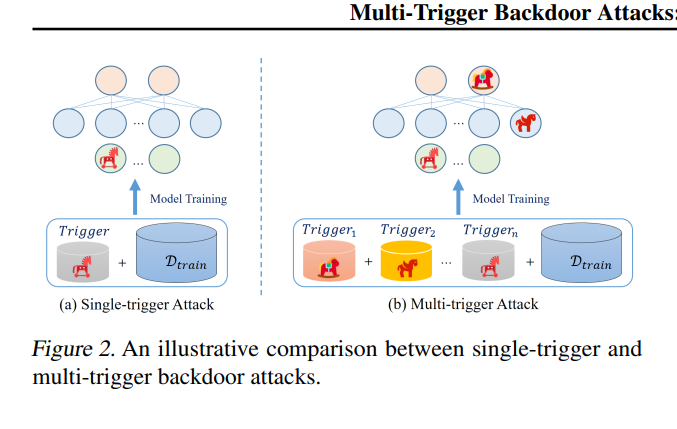 

(https://arxiv.org/pdf/2401.15295.pdf )

#### Модель угрозы
Мы возьмем, что один или более злоумышленников имеет доступ к нескольким тренировочным примерам, но ни один из них не может управлять процессом обучения. Они могут быть независимы или сотрудничать. Независимые злоумышленники отравляет разные тренировочные сэмпплы разными типами триггеров, когда командные могут отравлять одни и те же примеры в последовательном порядке, накладывая один триггер за другим.

Также может существовать супер-злоумышленник, который соединяет все атаки вместе или комбинирует множество триггеров в один гибридный или супер-триггер.


#### Определение единичной триггерной бэкдор атаки

$D= \{(x_i,y_i)\}^N_{i=1} x_i \in prediction$, где $x_i$ - тренировочное изображение и $y_i \in Y$ - метка. Бэкдор злоумышленник генерирует бэкдор экзепмляры с помощью триггер функции $tr: X \rightarrow X$.Для чистого примера, оно помечает $x$ в бэкдор сэмпл $x_b$, т.е. $x_b = tr(x)$ и  $y \rightarrow y_b$

Для сохранения скрытности и эффективности для бэкдор инъекции, злоумышленник случайно выбирает несколько тренировочных примеров для отравления, что создает множество бэкдор примеров $D_b = \{(x_b,y_b)\}$. 

Одиночно-триггерные бэкдор атаки (ОТБА) - те, которые вводит только единственный тип триггера в тренировочный датасет(т.е. только одна $tr(\cdot)$. 

Отравленный датасет определяется как $\hat{D} = D_c \cup D_b$. Где $D_c = \{x_c, y_c\}$ - множество чистых меток и сэмплов. $D_b = \{x_b, y_b\}$ - зараженное множество.

$\alpha = \frac {D_b} {\hat{D}}$ - коэффициент отравления.

Обучение модели на $\hat{D}$ заключается в: $$min_\theta\mathbb{E}_{D_c}[\mathcal{L}(f_\theta(x_c), y_c)] + \mathbb{E}_{D_b}[\mathcal{L}(f_\theta(x_b),y_b)] (1)$$

$\mathcal {L}$ - кроссэнтропия.

#### Определение множественно-триггерных бэкдор атак

Если атаки использует множество типов триггеров(от одного или более злоумышленников) для атаки одного датасета, мы называем их Множественно-трггерные бэкдор атаки(МТБА). 
Следовательно: $$D_b =\bigcup_{k=1}^m D^k_b = \bigcup_{k=1}^m \{(x_b^k, y_b^k)\}$$
где $x_b^k = tr_k(prediction)$ - отравленный сэмпл k-ой функцией $tr_k(\cdot)$, $D_b^k$ - подмножество отравленных примеров, отравленных $tr_k(\cdot)$ для всех меток $m$.

$\alpha = \sum_{k=1}^m \frac {|D_b^k|}{|\hat{D}|}$


### Стратегии отравления

#### Параллельное отравление

Есть множество независимых злоумышленников. В Этом случае, разумно почитать, что отравленные подмножества не пеесекаются друг с другом или два независимых злоумышленника имеют экстремально низкую веряотность для отравления одного и того же экземпляра.

$D^k_b =\{(x_b^k,y_b^k)\}|prediction^k_b = tr_k(x_s^k),x_s^k \in D^k_s$

$$min_\theta \mathbb{E}_{\textasciitilde D_c} [\mathcal{L} (f_\theta(x_c),y_c)] + \sum_{k=1}^m \mathbb{E}_{D^k_b} [\mathcal{L}(f_\theta(x_b^k),y_b^k)]$$

$\mathcal{L}$ - кроссэнтропия, $m$ - количество независимо отравленных подмножеств.

#### Последовательное отравление

У нас есть множество различных злоумышленников, которые атакуют один и тот же датасет в последовательном порядке, но множества датасета также не пересекаются. 

$\hat{D}_k = D_c \cup D_b^k = \{D \textbackslash D_s^k\} \cup D^k_b $

$$min_{\theta_k} \mathbb{E}_{(x,y) \textasciitilde \hat{D}_{k}} \mathcal {L}[(f_{\theta_{k}} (x), y)] $$

Следующий противник k+1 отравляет датасет $\hat{D}_k$ также как k-ый, т.е. $\hat{D}_{k+1} = D_c \cup D_b^k \cup ^{k+1}_b = \{D \textbackslash D_s^{k+1}\} \cup D^{k+1}_b $, следовательно

$$min_{\theta_{k+1}} \mathbb{E}_{(prediction,y) \textasciitilde \hat{D}_{k+1}} \mathcal {L}[(f_{\theta_{k+1}} (x), y)] $$
После вышеупомянутгго последовательного обучения, модель $(f_{\theta_{k+1}}$ превразаеься в последовательно бэкдорную модель, которая содержит оба триггера $tr_k$ и $tr_{k+1}$


#### Гибридно-триггерное отравление

Стратегия при которой существует супер-злоумышленник, который комбинирует разные триггеры в один гибриднный триггер, для достижения эффекта множества триггеров.

Есть чистый экземпляр prediction, гибрдно-триггерная атака отравляет его с m простых триггеров $\mathcal {T} = \{tr_k\}^m_{k=1}$, следующим образом:
$$x_h = tr_m \circ tr_{m-1} \cdots \circ tr_1(x)$$
где мы использем мягкое смешивание в каждом шаге, т.е. $tr_k \circ tr_{k-1} (x) = \lambda \cdot tr_k + (1-\lambda)x_b^{k-1}$

Отравленный датасет  может быть определен так: $\hat {D} = D_c \cup D_h = {D \textbackslash D_s} \cup D_h$, где $D_h =\{(x_h,y_h\}$ - подмножетсов полученное мягким смешиванием, оно получено из $D_s \subset D$ - сэмлов, доступных злоумышленнику.

Далее злоумшыленник тренирует модель на $\hat{D}$:

$$min_{\theta} \mathbb{E}_{D_c} [\mathcal{L} (f_\theta(x_c),y_c)] + \mathbb{E}_{D_h} [\mathcal{L} (f_\theta(x_h),y_h)]$$

#### Модификация меток
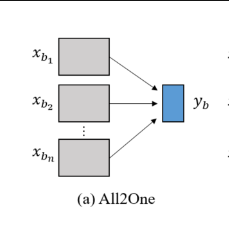

Стратегия меняет все бэкдор сэмплы на фиксированный целевую бэкдор метку $y_t$, т.е. все сэмплы $x_{b / h} \in D_{b / h}$ имеют одинаковую метку $y_t$

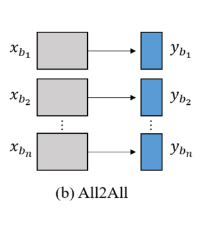

Меняем метку бэкдор сэмпла $x_b$ (сделанную из чистого) в $y_b = (y+1)\%K$,где K - полное количество классов, y - оригинальная метка $x/x_b$
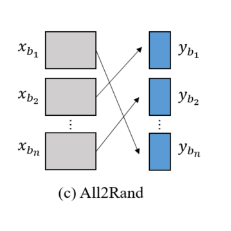
 
Меняем метку $x_b$ на $y_b = Random(\{1,2,\cdots,K\})$ , Random - случайная функция. 

## Выводы